In [1]:
%matplotlib notebook

In [2]:
#The fundamental files that this uses to generate all else from are:
#'skeleton.bvh'
#The extra 'timecodes.json' is used for blender animation
#Also 'markers.json' isnt used since Sinead worked on pose from RGBD
#Thus doesnt use the mocap markers for pose in her programs

In [3]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle

import sys, os
from utils import utils
from scipy.spatial.transform import Rotation as Rsci

In [235]:
def SetValues():
    pathToMainDataset = 'C:/Users/georg/OneDrive/Desktop/Research/Data'
    dog = 'dog1'
    motion = 'trot' #doesnt seem to work proper for jump due to skelNodes.pkl
    cameraFrame = 0
    
    return pathToMainDataset, dog, motion, cameraFrame

In [236]:
pathToMainDataset, dog, motion, cameraFrame = SetValues()

skelFrame = cameraFrame+1
    
pathToMotion = os.path.join(pathToMainDataset, dog, 'motion_%s'%motion)			
bvhSkelFile = os.path.join(pathToMotion, 'motion_capture', 'skeleton.bvh')
skelConnections_asNp = os.path.join(pathToMotion, 'motion_capture', 'skelConnections.npy')
skelNodes_asPck = os.path.join(pathToMotion, 'motion_capture', 'skelNodes.pkl')
bvhSkelFile_asNp = bvhSkelFile[:bvhSkelFile.rfind('.')] + '.npy'
markerFile = os.path.join(pathToMotion, 'motion_capture', 'markers.json')

# ----------------------------------- load the skeleton -----------------------------
if os.path.isfile(bvhSkelFile_asNp):
    bvhJoints = np.load(bvhSkelFile_asNp)
    
    #gf321 utility:
    skeletons_raw = np.load(bvhSkelFile_asNp)
    
    print(bvhJoints.shape)
    skelConnections = np.load(skelConnections_asNp)
    with open(skelNodes_asPck, 'rb') as f:
        nodes = pickle.load(f)
else:
    bvhJoints, skelConnections, nodes = utils.ReadBvhFile(bvhSkelFile, False)
    bvhJoints = utils.MovePointsOutOfMayaCoordSystem(bvhJoints, 1)
        
    with open(skelNodes_asPck, 'wb') as f:
        pickle.dump(nodes, f)
    np.save(bvhSkelFile_asNp, bvhJoints)
    np.save(skelConnections_asNp, skelConnections)

# load skinning weights and neutral mesh
pathToSkinningWeights = os.path.join(pathToMainDataset, dog, 'meta', 'skinningWeights.mat')
weights = utils.LoadMatFile(pathToSkinningWeights)

pathToObj = os.path.join(pathToMainDataset, dog, 'meta', 'neutralMesh.obj')
meshObj = utils.LoadObjFile(pathToObj, rotate=True)
verts_neutral = meshObj['vertices']
    
J_neutral = bvhJoints[:,:,0] # the first frame of the bvh file is the neutral skeleton
numJoints = J_neutral.shape[0]
    
# rotate about z, to match dynaDog_np.py
verts_neutral = verts_neutral[:,np.array((1,0,2))]
verts_neutral[:,0] *= -1
J_neutral = J_neutral[:,np.array((1,0,2))]
J_neutral[:,0] *= -1
    
# the world positions of the joints in this frame
bvhJoints = bvhJoints[:,:,skelFrame]
print(bvhJoints.shape)
bvhJoints = bvhJoints[:,np.array((1,0,2))]
print(bvhJoints.shape)
bvhJoints[:,0] *= -1
print(bvhJoints.shape)
    
root_trans = bvhJoints[0]

world_rot = utils.GetWorldRotationsForFrame(nodes, skelFrame, 'rodrigues')
    
G = np.zeros((numJoints,4,4))
# to get the correct rotations, we have to rearrange the axis
for jntIdx, rot in enumerate(world_rot): 
    G[jntIdx,0:3,0:3] = Rsci.from_rotvec(rot).as_dcm()
        
    # remove root translation
    G[jntIdx,0:3,3] = bvhJoints[jntIdx] - bvhJoints[0]
    G[jntIdx,3,3] = 1

# remove the neutral pose from the transformations
G = G - utils.pack(
    np.matmul(
    G,
    np.hstack([J_neutral, np.zeros([numJoints, 1])]).reshape([numJoints, 4, 1])
    )
    )

# transform each vertex
T = np.tensordot(weights, G, axes=[[1], [0]])
rest_shape_h = np.hstack((verts_neutral, np.ones([verts_neutral.shape[0], 1])))
# T.shape (2426, 4, 4) rest_shape_h.shape (2426, 4)
v = np.matmul(T, rest_shape_h.reshape([-1, 4, 1])).reshape([-1, 4])[:, :3]
    
# apply root translation
verts = v + root_trans.reshape([1, 3]) 


(43, 3, 148)
(43, 3)
(43, 3)
(43, 3)


In [ ]:
######################################

In [237]:
#Specific part to test for nonconstant offsets!

#-----------------------------load mocap markers----------------

with open(markerFile, 'r') as m:
    
    markerdict = json.load(m)
    
    #Divide by 3 because X,Y,Z data kept in seperate keys consecutively
    num_markers = int(len(markerdict.keys())/3) 
    num_frames = len(markerdict['FHED.translateX'])
    
    markers = np.zeros((num_frames, num_markers,3))
    marker_names = list(markerdict.keys())
    
    for key_ind in range(len(marker_names)):
        
        dim = key_ind%3 #allows us to sort x,y,z parts of marker data
        marker_ind = int(key_ind/3) #similar trick for proper indexing
        
        for frame in range(num_frames):
            markers[frame,marker_ind,dim] = markerdict[marker_names[key_ind]][frame]

#---------------------------load skeleton again---------------------

#skeletons_raw = np.load(bvhSkelFile_asNp)      #used above    
skeletons = np.array(skeletons_raw)
skeletons = np.moveaxis(skeletons,-1,0) #move frames to first array position
skeletons = np.delete(skeletons,(0),axis=0) #delete 0th frame of data (a neutral frame I think!)

#correctly align markers with skeleton
#requires x->x, y->z, z->-y transforms
markers_copy = np.array(markers)
markers[:,:,2] = markers_copy[:,:,1] #y->z
markers[:,:,1] = -markers_copy[:,:,2] #z->-y

#All ready!

In [126]:
print(markers.shape)
print(skeletons.shape)

(147, 64, 3)
(147, 43, 3)


<IPython.core.display.Javascript object>


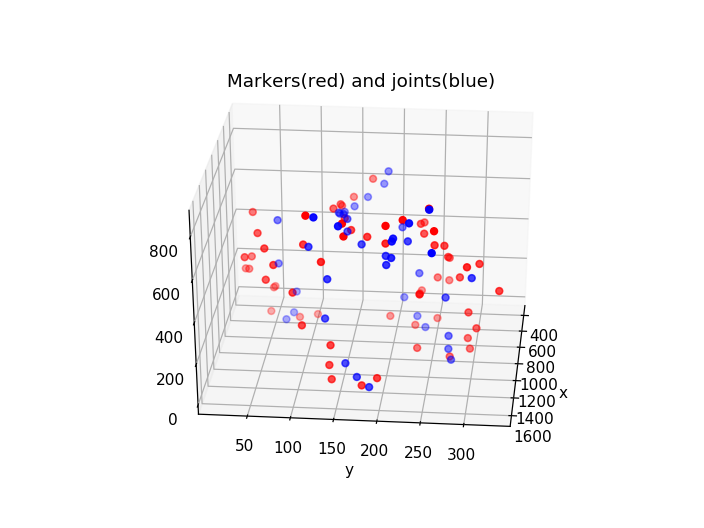

In [238]:
fig = plt.figure(); ax = fig.add_subplot(111, projection='3d')

fr=100 #frame number

ax.scatter(markers[fr,:,0],markers[fr,:,1],markers[fr,:,2], c='r')
ax.scatter(skeletons[fr,:,0],skeletons[fr,:,1],skeletons[fr,:,2], c='b')

ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_aspect('auto')
plt.title('Markers(red) and joints(blue)')
plt.show()

In [239]:
#Now to compute the offsets matrix Z:
#Z should have dimension n*m*j*3

num_markers = markers.shape[1]
num_joints = skeletons.shape[1]

Z = np.zeros((markers.shape[0],num_markers,num_joints,3))
Znorms = np.zeros((markers.shape[0],num_markers,num_joints)) #l2 norms of each difference later
Zstds = np.zeros((num_markers,num_joints)) #np.std of the l2 norms

#Loop to construct offset matrix
#Loop through frames last so we can construct Zstds
for marker in range(num_markers):
    for joint in range(num_joints):
        for frame in range(markers.shape[0]):
    
            Z[frame][marker][joint] = markers[frame][marker] - skeletons[frame][joint]
            Znorms[frame][marker][joint] = np.linalg.norm(Z[frame][marker][joint])
        
        Zstds[marker][joint] = Znorms[:,marker,joint].std()

In [250]:
for m in range(num_markers):
    all_good = 'all good, all markers have a distance from a joint with std<2.5mm'
    if m not in np.where(Zstds<2.5)[0]:
        all_good = 'found marker with std>2.5mm'

print(all_good)

all good, all markers have a distance from a joint with std<2.5mm


In [165]:
Znorms.shape

(147,)

In [ ]:
###################################################

<IPython.core.display.Javascript object>


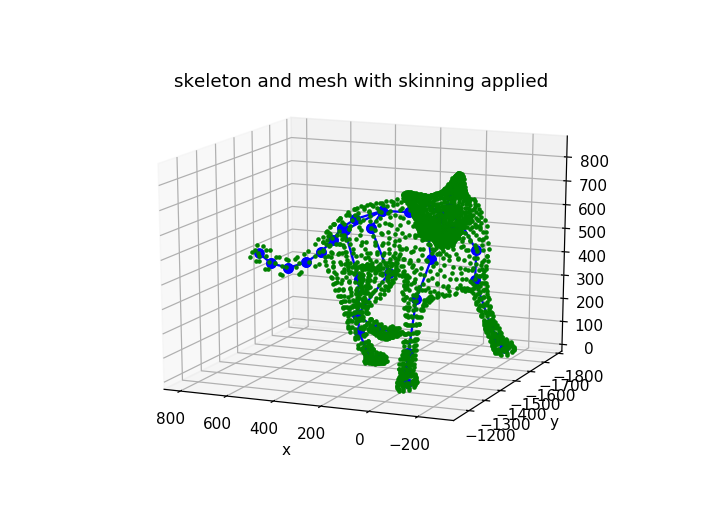

In [6]:
fig = plt.figure(); ax = fig.add_subplot(111, projection='3d')	
ax, fig = utils.Plot3d(bvhJoints, connections=skelConnections, style='bo-', ax=ax, differentColoursForSides=False)
ax.plot(verts[:,0], verts[:,1], verts[:,2], 'go', markersize=2)
plt.title('skeleton and mesh with skinning applied')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_aspect('auto')
plt.show()

In [7]:
#bvh file for skeleton
bvhJoints.shape

(43, 3)

In [8]:
#skeleton connections. Sometimes array, sometimes list.
np.asarray(skelConnections).shape

(43,)

In [9]:
#Skinning weights of vertices of mesh
weights.shape

(2426, 43)

In [10]:
#Location of vertices of neutral mesh
verts_neutral.shape

(2426, 3)

In [11]:
#Location of the root
root_trans

array([  332.426, -1648.93 ,   575.842])

In [12]:
#Transformed vertices
verts.shape

(2426, 3)